# *Prácitca* 2 - Segmentación mediante KNN
**Aprendizaje de máquina para visión computacional 2024-2**

Integrantes:
- Alejandro
- Naomi
- Victor

El siguiente código presenta un ejemplo de como realizar la segmentación de imagenes implementado con scikit-image (skimage) y la técnica KNN de sklearn. Este modelo se basa en **clasificar pixeles**, por lo que los datos de entrada serán representaciones de pixeles y las etiquetas corresponden a las clases.

Utiliza imágenes de la base de datos ISIC sobre cáncer de piel con sus respectivas máscaras.

Nota: La ejecución puede tardar un tiempo considerable dependiendo del tamaño de la imagen, principalmente al usar extracción de características.

Objetivos de la práctica:
- Dividir los dadtos proporcionados en conjuntos de entrenamiento y prueba.
- Replicar el ejercicio de muestra con los datos implementando un clasificador KNN con todas las imagenes del conjunto.
- Explorar diferentes valores para el hiperparametro.
- Explorar la función para extraer las caracteristicas y variar las coordendas en tamaños de cuadros delimitadores para alguna imagen individual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
from PIL import Image
from sklearn.metrics import cohen_kappa_score
def calculaIoU(gtMask, predMask):
    # Calcula verdaderos positivos, falsos positivos, and falsos negativos
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(gtMask)):
        for j in range(len(gtMask[0])):
            if gtMask[i][j] == 1 and predMask[i][j] == 2:
                tp += 1
            elif gtMask[i][j] == 0 and predMask[i][j] == 2:
                fp += 1
            elif gtMask[i][j] == 1 and predMask[i][j] == 1:
                fn += 1

    # Calcula IoU
    iou = tp / (tp + fp + fn)

    return iou
def calculaIoUMod(gtMask, predMask):
        # Calcula verdaderos positivos, falsos positivos, and falsos negativos
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 2:
                    tp += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                    tp+=1
                elif gtMask[i][j] == 0 and predMask[i][j] == 2: 
                    fp += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 1:
                    fn += 1

        # Calcula IoU
        iou = tp / (tp + fp + fn)

        return iou

def kappa(gtMask, predMask):
        # Calcula kappa
        p_p = 0
        p_m = 0
        m_p = 0
        m_m = 0
        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 2: #melanoma control - melanoma pred
                    m_m += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                    p_p+=1
                elif gtMask[i][j] == 0 and predMask[i][j] == 2: 
                    p_m += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 1:
                    m_p += 1
        total = p_p+ p_m+ m_p+ m_m
        p0 =(p_p + m_m)/ total
        pe =  (((m_m/total + m_p/total)*(m_m/total + p_m/total)) + ((p_m/total + p_p/total)*( m_p/total + p_p/total)))
        # Calcula kappa
        kappa = (p0 - pe) / (1 -pe)
        return kappa

## Imagenes originales 

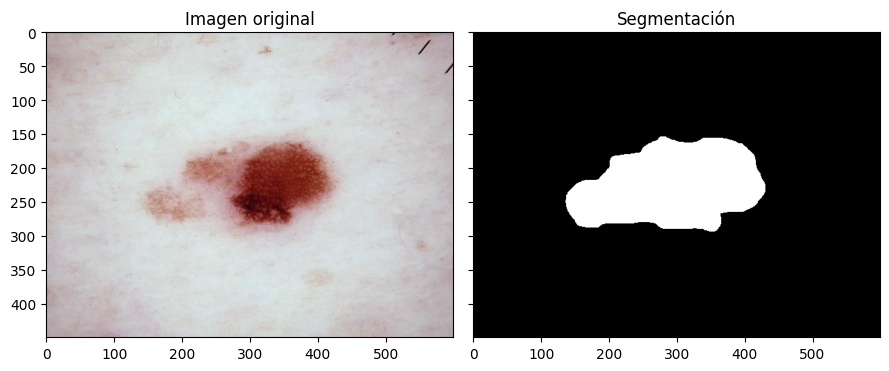

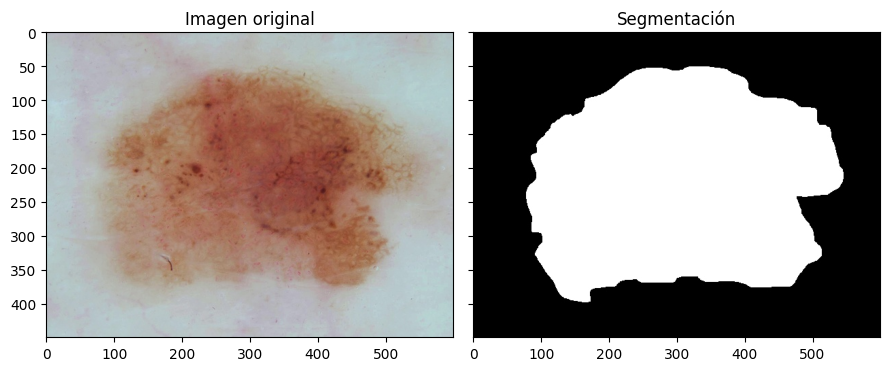

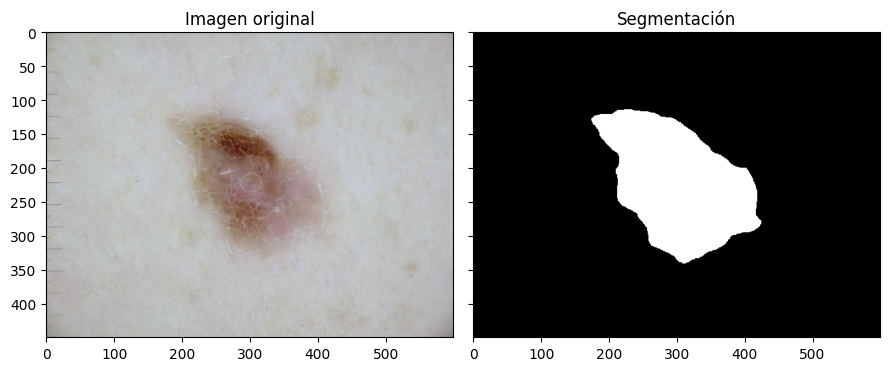

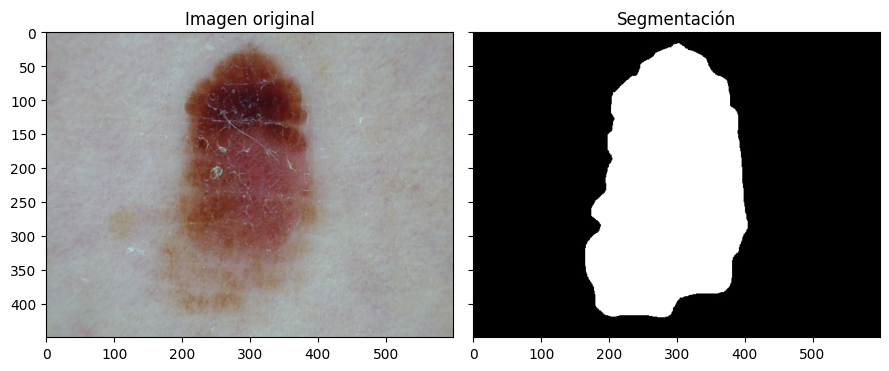

In [19]:
p_imagenes =[
    "ISIC_0024313.jpg",
    "ISIC_0024351.jpg",
    "ISIC_0024481.jpg",
    "ISIC_0024496.jpg",
]
imgs = [plt.imread("ISIC_segmentation/"+x) for x in p_imagenes]
imgs_seg = [Image.open("ISIC_segmentation/"+x.replace(".jpg","_segmentation.jpg")).convert("L") for x in p_imagenes]
imgs_train_labels = []
for img, img_s in zip(imgs,imgs_seg):
    imgs_train_labels.append(np.zeros(img.shape[:2], dtype=np.uint8))
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(img)
    #ax[0].contour(img_s)
    ax[0].set_title("Imagen original")
    ax[1].imshow(img_s, cmap='gray')
    ax[1].set_title("Segmentación")
    fig.tight_layout()

## Áreas de entrenamiento y clasificación con KNN, vecinos = 3

In [3]:
#ROIs
## imagen 1
imgs_train_labels[0][0:150 ,0:150] = 1 # piel 
imgs_train_labels[0][200:250, 250:300] = 2  # melanoma

## imagen 2
imgs_train_labels[1][0:100 ,500:600] = 1 # piel 
imgs_train_labels[1][150:300, 100:350] = 2  # melanoma

## imagen 3
imgs_train_labels[2][350:450 ,100:500] = 1 # piel 
imgs_train_labels[2][125:225, 210:350] = 2  # melanoma

## imagen 3
imgs_train_labels[3][0:200 ,0:150] = 1 # piel 
imgs_train_labels[3][100:350, 200:400] = 2  # melanoma

imagen 1: porcentaje de segmentación correcta: 93.91%, 99.49%, k= 0.11
imagen 2: porcentaje de segmentación correcta: 93.31%, 93.77%, k= 0.11
imagen 3: porcentaje de segmentación correcta: 99.62%, 70.82%, k= 0.00
imagen 4: porcentaje de segmentación correcta: 98.66%, 81.35%, k= 0.02


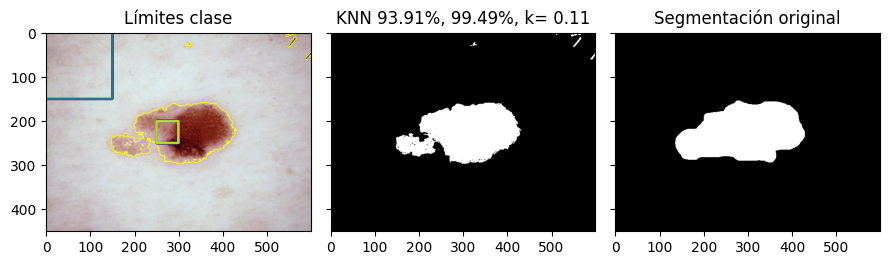

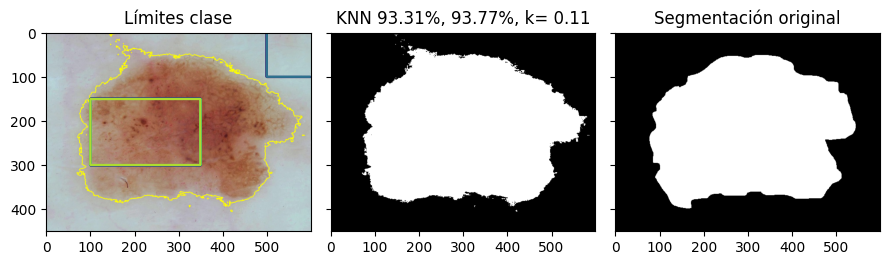

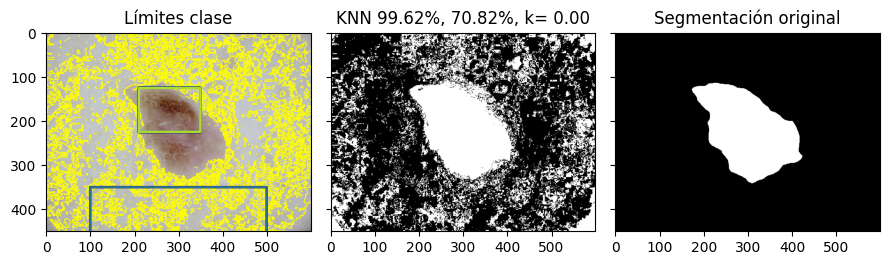

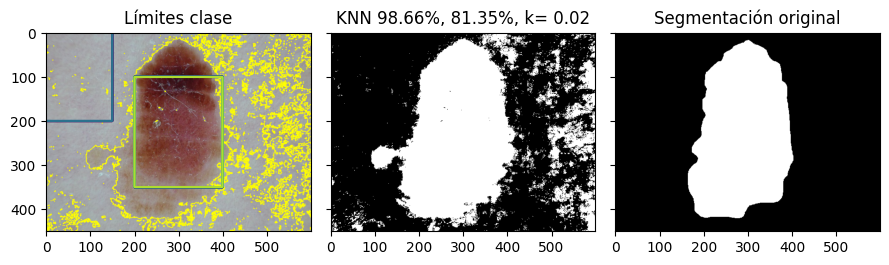

In [4]:
clasificador = KNeighborsClassifier(n_neighbors=3)
precision = {}
i =1
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    clf = future.fit_segmenter(training_labels, img, clasificador)
    result = future.predict_segmenter(img, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                  round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                  kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clase')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    fig.tight_layout()

    i+=1
for k,v in precision.items():
    print(f"imagen {k}: porcentaje de segmentación correcta: {v[0]:.2f}%, {v[1]:.2f}%, k= {v[2]:.2f}")

## KNN con extracción de caracteristicas

imagen 1: porcentaje de segmentación correcta: 92.14%, 99.46%, k= 0.14
imagen 2: porcentaje de segmentación correcta: 93.42%, 91.56%, k= 0.11
imagen 3: porcentaje de segmentación correcta: 97.79%, 93.81%, k= 0.04
imagen 4: porcentaje de segmentación correcta: 98.13%, 79.63%, k= 0.03


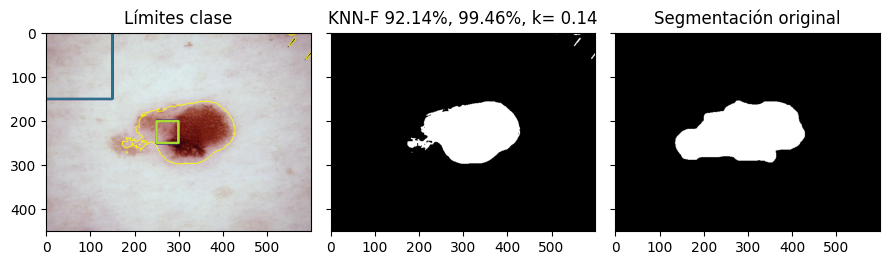

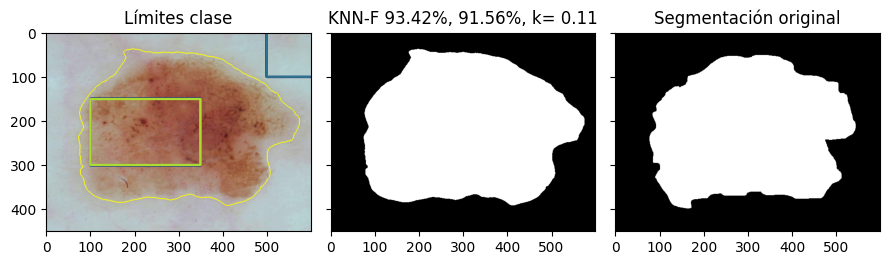

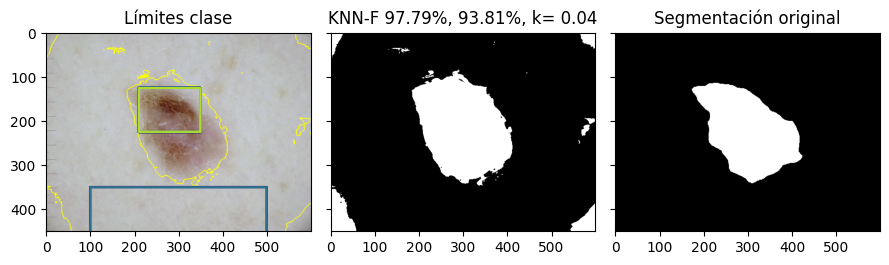

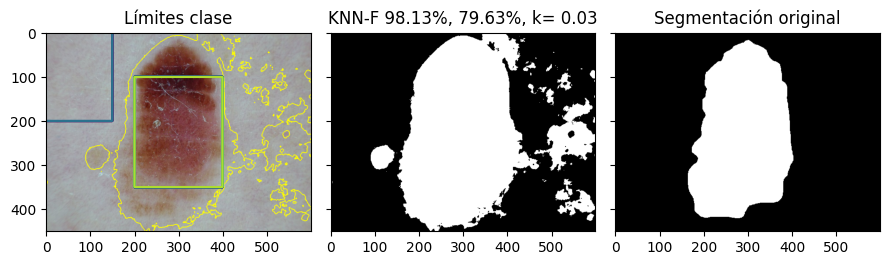

In [5]:
## Con extracción de caracteristicas
sigma_min = 1
sigma_max = 16
i =1
precision = {}
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    
    features = feature.multiscale_basic_features(img,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    clf = future.fit_segmenter(training_labels, features, clasificador)
    result = future.predict_segmenter(features, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                    round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                    kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clase')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN-F {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    #fig.savefig(f'seg_features_img{i}_sigma{sigma_min}-{sigma_max}_knn{5}.png')
    fig.tight_layout()
    i+=1

for k,v in precision.items():
    print(f"imagen {k}: porcentaje de segmentación correcta: {v[0]:.2f}%, {v[1]:.2f}%, k= {v[2]:.2f}")
    

## Actualización de cuadros delimitadores

imagen 1: porcentaje de segmentación correcta: 92.33%, 99.44%, k= 0.14
imagen 2: porcentaje de segmentación correcta: 93.42%, 91.56%, k= 0.11
imagen 3: porcentaje de segmentación correcta: 90.38%, 99.09%, k= 0.17
imagen 4: porcentaje de segmentación correcta: 93.12%, 96.15%, k= 0.12


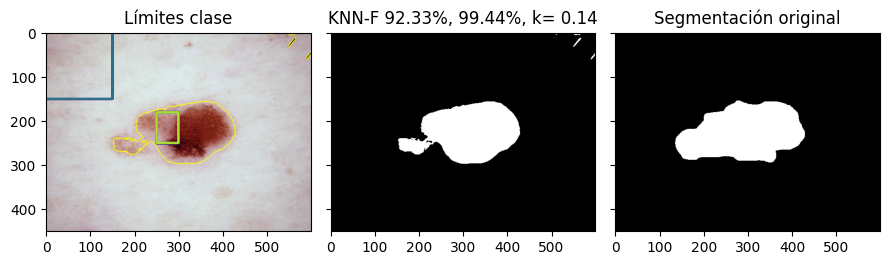

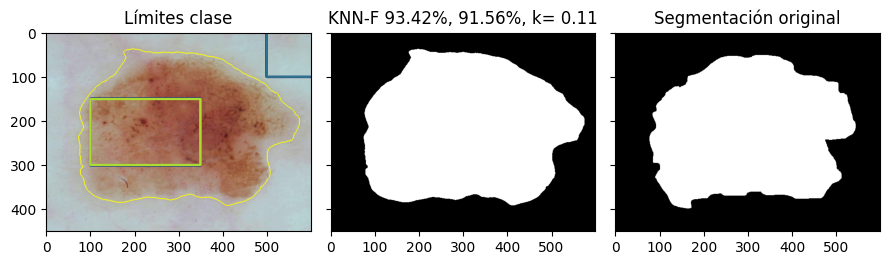

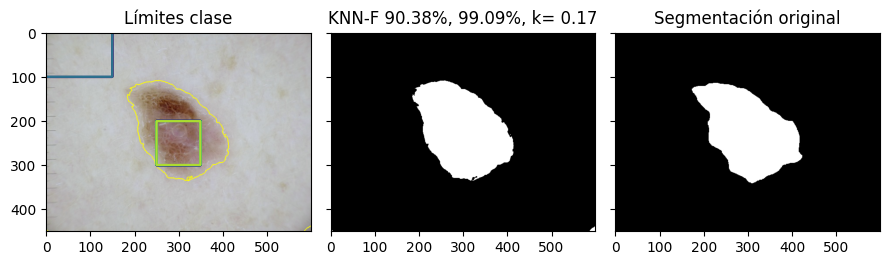

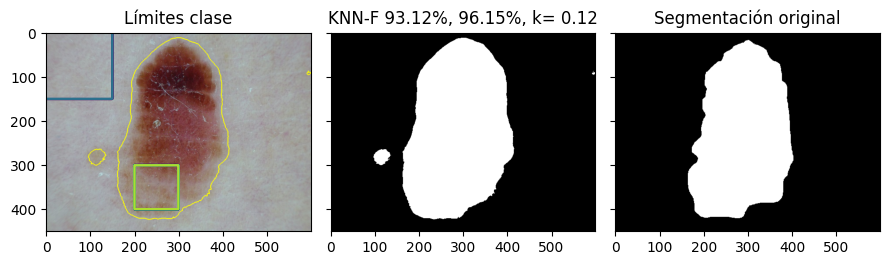

In [6]:
imgs_train_labels = [np.zeros(img.shape[:2], dtype=np.uint8) for img in imgs]

#ROIs
## imagen 1
imgs_train_labels[0][0:150 ,0:150] = 1 # piel 
imgs_train_labels[0][180:250, 250:300] = 2  # melanoma

## imagen 2
imgs_train_labels[1][0:100 ,500:600] = 1 # piel 
imgs_train_labels[1][150:300, 100:350] = 2  # melanoma

## imagen 3
imgs_train_labels[2][0:100 ,0:150] = 1 # piel 
imgs_train_labels[2][200:300, 250:350] = 2  # melanoma

## imagen 4
imgs_train_labels[3][0:150 ,0:150] = 1 # piel 
imgs_train_labels[3][300:400, 200:300] = 2  # melanoma

## Con extracción de caracteristicas
sigma_min = 1
sigma_max = 16
i =1
precision={}
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    
    features = feature.multiscale_basic_features(img,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    clf = future.fit_segmenter(training_labels, features, clasificador)
    result = future.predict_segmenter(features, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clase')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN-F {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    #fig.savefig(f'seg_features__box4_img{i}_sigma{sigma_min}-{sigma_max}_knn{5}.png')
    i+=1
    fig.tight_layout()

for k,v in precision.items():
    print(f"imagen {k}: porcentaje de segmentación correcta: {v[0]:.2f}%, {v[1]:.2f}%, k= {v[2]:.2f}")

## Modificación de hiperparametros, vecinos = 5, sigma_min = 5

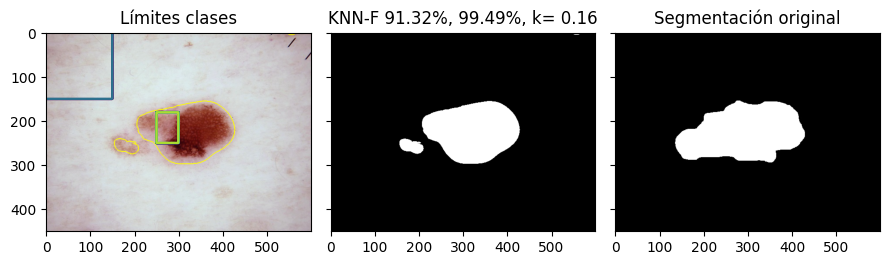

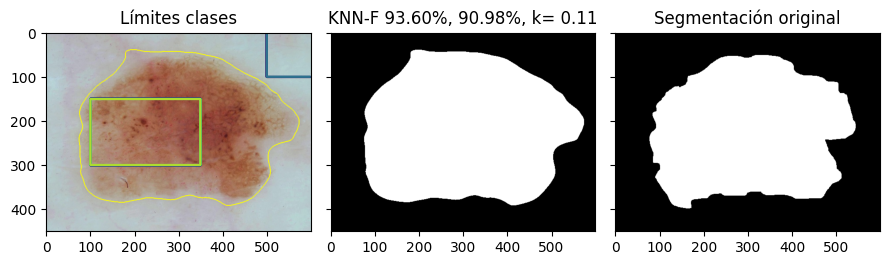

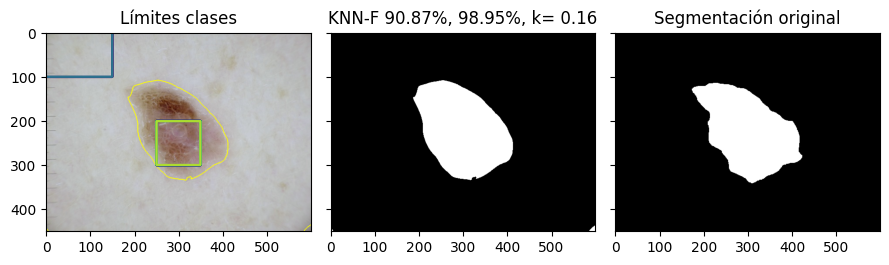

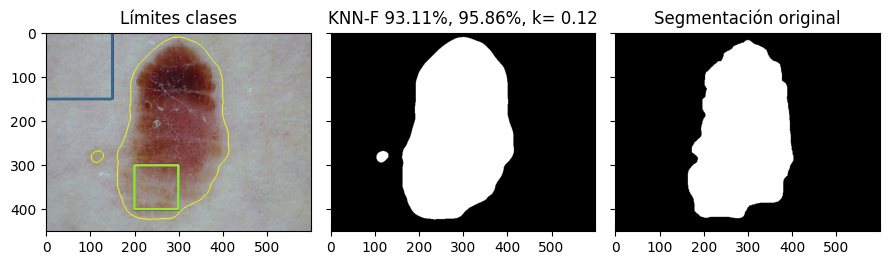

In [7]:
sigma_min = 5
sigma_max = 16
vecinos =5
clasificador = KNeighborsClassifier(n_neighbors=vecinos)
i =0
precision ={}
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    
    features = feature.multiscale_basic_features(img,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    clf = future.fit_segmenter(training_labels, features, clasificador)
    result = future.predict_segmenter(features, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clases')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN-F {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    #fig.savefig(f'seg_features__box4_img{i}_sigma{sigma_min}-{sigma_max}_knn{vecinos}.png')
    i+=1
    fig.tight_layout()

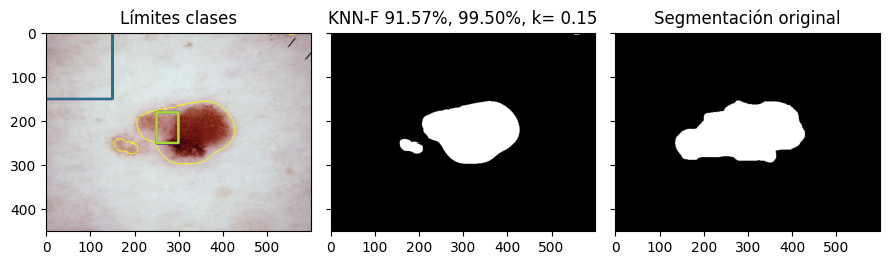

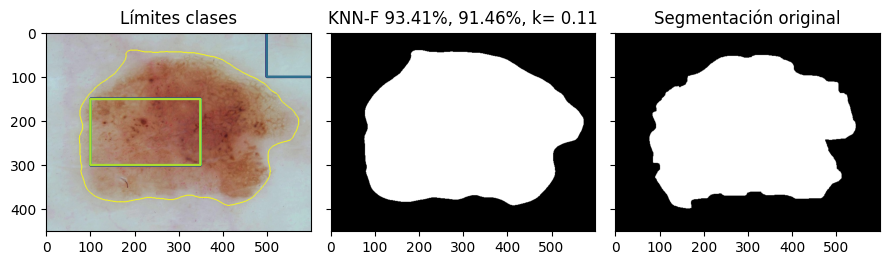

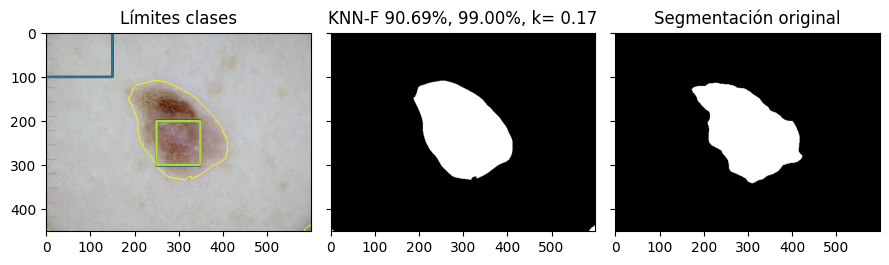

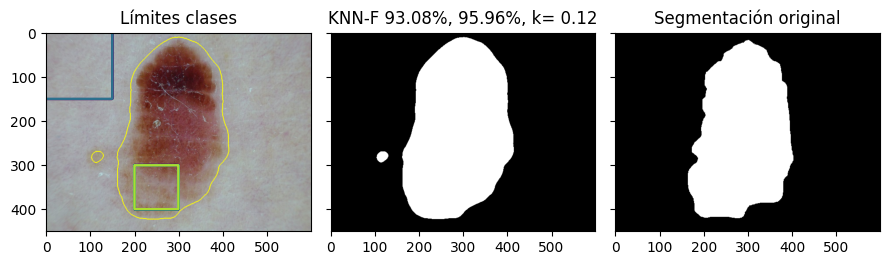

In [8]:
sigma_min = 5
sigma_max = 16
vecinos =8
clasificador = KNeighborsClassifier(n_neighbors=vecinos)
i =0
precision ={}
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    
    features = feature.multiscale_basic_features(img,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    clf = future.fit_segmenter(training_labels, features, clasificador)
    result = future.predict_segmenter(features, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clases')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN-F {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    #fig.savefig(f'seg_features__box4_img{i}_sigma{sigma_min}-{sigma_max}_knn{vecinos}.png')
    i+=1
    fig.tight_layout()

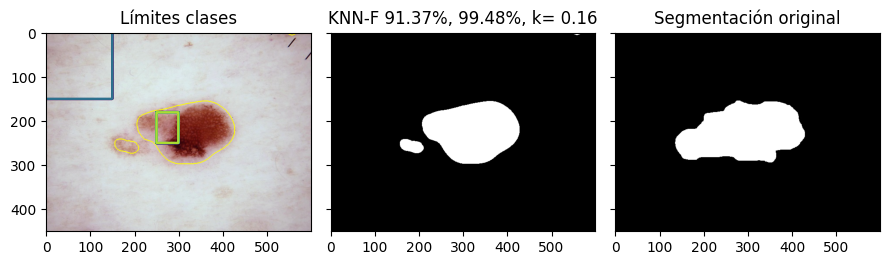

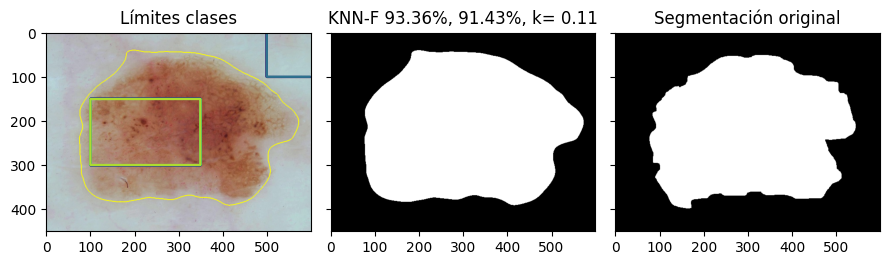

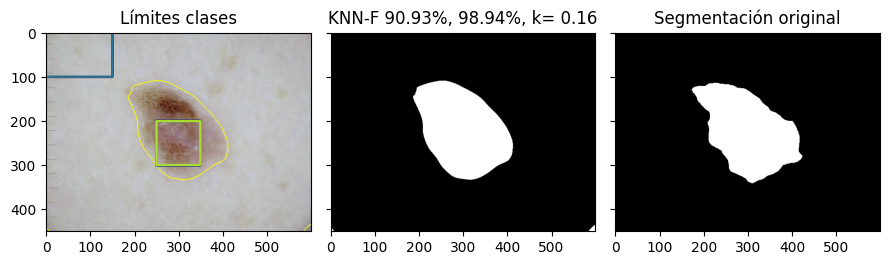

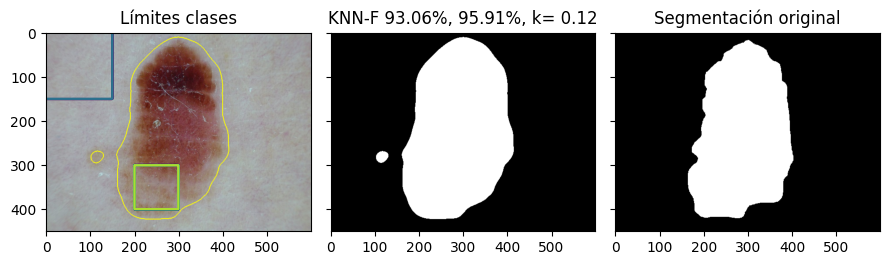

In [10]:
sigma_min = 7
sigma_max = 16
vecinos =7
clasificador = KNeighborsClassifier(n_neighbors=vecinos)
i =0
precision ={}
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    
    features = feature.multiscale_basic_features(img,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    clf = future.fit_segmenter(training_labels, features, clasificador)
    result = future.predict_segmenter(features, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clases')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN-F {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    #fig.savefig(f'seg_features__box4_img{i}_sigma{sigma_min}-{sigma_max}_knn{vecinos}.png')
    i+=1
    fig.tight_layout()

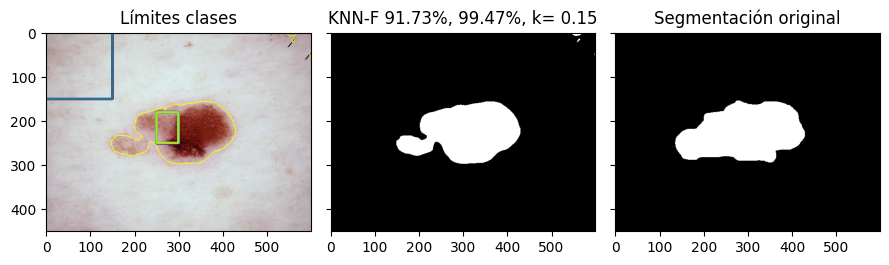

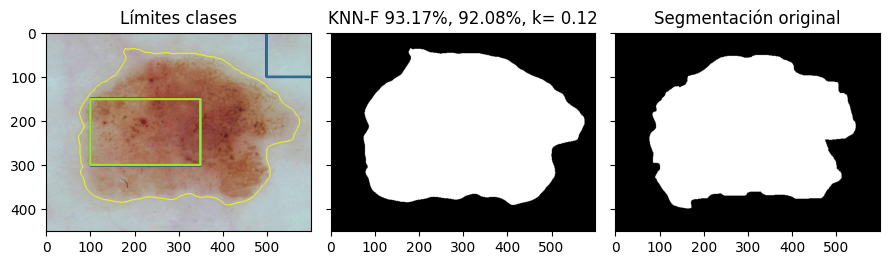

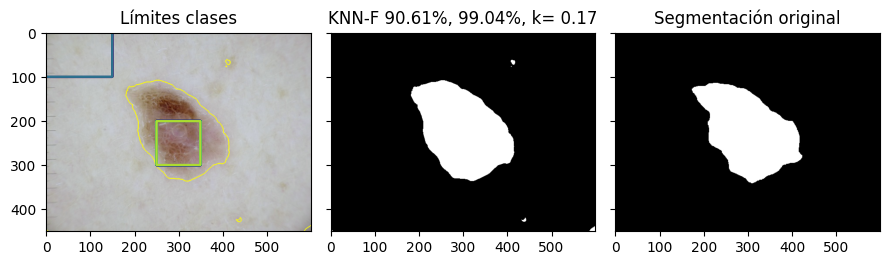

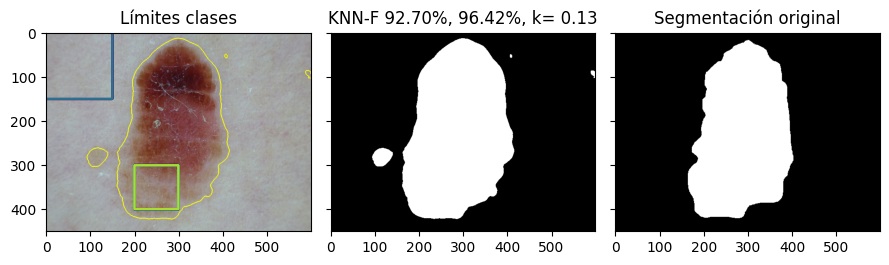

In [17]:
sigma_min = 3
sigma_max = 9
vecinos =3
clasificador = KNeighborsClassifier(n_neighbors=vecinos)
i =0
precision ={}
for img, training_labels,img_seg in zip(imgs,imgs_train_labels,imgs_seg):
    
    features = feature.multiscale_basic_features(img,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    clf = future.fit_segmenter(training_labels, features, clasificador)
    result = future.predict_segmenter(features, clf)
    precision[i]=[round(1-calculaIoU(np.asarray(img_seg), result),4)*100,
                round(calculaIoUMod(np.asarray(img_seg), result),4)*100, 
                kappa(np.asarray(img_seg), result)]
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Límites clases')
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title(f'KNN-F {precision[i][0]:.2f}%, {precision[i][1]:.2f}%, k= {precision[i][2]:.2f}')
    ax[2].imshow(img_seg, cmap='gray')
    ax[2].set_title('Segmentación original')
    #fig.savefig(f'seg_features__box4_img{i}_sigma{sigma_min}-{sigma_max}_knn{vecinos}.png')
    i+=1
    fig.tight_layout()